<a href="https://colab.research.google.com/github/fabriziobasso/Time_Series_Files/blob/main/Time_Series_Data_Formats_Made_Easy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Data Formats Made Easy**

The Pandas data frame in most cases is sufficient to handle time series data. If the data is univariate time series, a Pandas series with a time index will work just fine. If the data is multivariate time series, a 2-dimensional Pandas data frame will work well. But how about a time series with probabilistic forecasts that have multiple values in each period? Figure (A) shows a multivariate case with the sales and temperature variables. The sales forecasts for each period have low, medium, and high possible values. Although Pandas may still be able to store this dataset, there are other more effective data formats designed to handle data with increasing complexity. A good understanding of the data formats will increase your productivity in time series modeling projects. This is the goal of the chapter.

We will cover the data formats of the DarTS, GluonTS, Sktime, pmdarima, and Prophet/NeuralProphet libraries. Because Sktime, pmdarima, and Prophet/NeuralProphet are all pandas-compatible, we just need to spend more time on

    - DarTS
    - GluonTS

Let’s have a learning strategy to digest them. Because the Pandas data frame is the common ground for most data scientists, let’s use Pandas as the glue among these Python libraries. We will observe the transformations of a Pandas data frame by converting it back and forth between these libraries. Additionally, we will explain long-form and wide-form data, and how to convert them between libraries.

[LINK](https://github.com/dataman-git/modern-time-series/blob/main/11_time_series_data_formats.ipynb) Github

[LINK](https://medium.com/dataman-in-ai/time-series-data-formats-made-easy-df4191531e3f) Medium

**Software requirement**

Please pip install the following libraries:

In [1]:
%%capture
!pip install darts gluonts sktime pmdarima neuralprophet

### Get a long-form dataset

We will use the Walmart dataset on Kaggle.com in this chapter. This dataset has the data for 45 Walmart stores. The data for each store are multivariate time series data in multiple columns. They are stacked vertically into a long dataset. A long-form data structure means the data of all groups are stacked vertically. Let’s load the dataset into a Pandas data frame.

In [3]:
#import darts
import neuralprophet

%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [15]:
%%time
# Setting rc parameters in seaborn for plots and graphs-
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
#sns.set_theme(style="ticks", context="notebook")
sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

CPU times: user 2.5 ms, sys: 53 µs, total: 2.55 ms
Wall time: 5.81 ms


<Figure size 640x480 with 0 Axes>

In [5]:
%%capture
# Connect to Colab:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
models_folders = "/content/drive/MyDrive/Exercises/Time_Series_Studies/Scripts/Modern Time Series - Book/Chapter 5: Time Series Data Formats Made Easy/"
os.chdir(models_folders)

In [10]:
data = pd.read_csv('Walmart.csv', delimiter=",")
data['ds'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.index = data['ds']
data = data.drop('Date', axis=1)
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,ds
ds,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05


The code converts the string column “Date” to datetime format in Pandas. This step is essential because other libraries often require the date field to be a Pandas datatime format. Figure (B) shows the first few records.

This dataset contains

    * Date — the week of sales
    * Store — the store number
    * Weekly sales — sales for a store
    * Holiday flag — whether the week is a special holiday week 1 — Holiday week 0 — Non-holiday week
    * Temperature — Temperature on the day of sale
    * Fuel price — Cost of fuel in the region
    * And two macroeconomic indicators that can affect retail sales: the consumer price index, and the unemployment rate. Each store has 143 weeks of data.

## Learn to convert a long-form dataset to a wide-form

A wide-form data structure means the multivariate time series data of different groups are joint horizontally by the same time index. Let’s take only the “weekly sales” column for all stores, then pivot the weekly sales by store and time. The columns of the new data frame will be store 1 to 45, and the rows of the data frame will be weeks. It shall create a data frame with 45 columns and 143 rows.

In [11]:
data.dtypes

Store                    int64
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
ds              datetime64[ns]
dtype: object

In [19]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,ds
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2011-06-17 00:00:00
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010-02-05 00:00:00
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010-10-08 00:00:00
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011-06-17 00:00:00
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012-02-24 00:00:00
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012-10-26 00:00:00
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,NaN


Text(0.5, 1.0, 'Walmart Weekly Sales of Store 1 - 10')

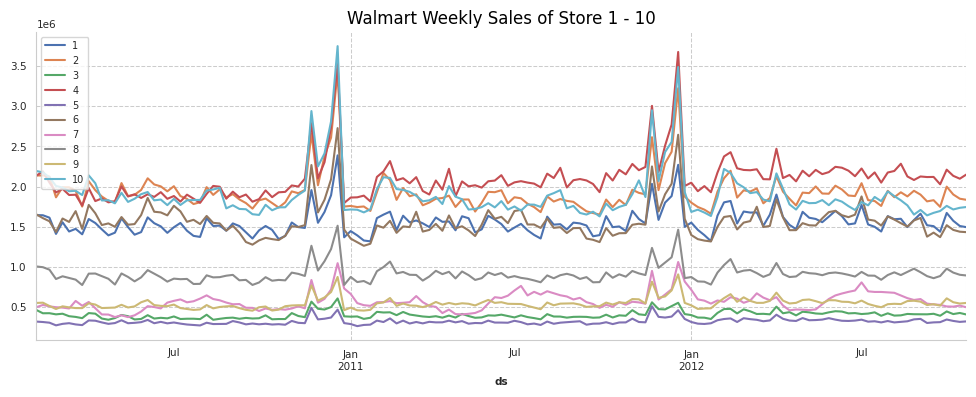

In [24]:
# pivot the data into the correct shape
storewide = data.pivot(index='ds', columns='Store', values='Weekly_Sales')
storewide = storewide.loc[:,1:10] # Plot only Store 1 - 10
# plot the pivoted dataframe
storewide.plot(figsize=(12, 4))
plt.legend(loc='upper left')
plt.title("Walmart Weekly Sales of Store 1 - 10")

Let’s inspect the time index. It is a Pandas DateTimeIndex.

In [26]:
print(storewide.index)

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='ds', length=143, freq=None)


Notice the values in the data frame are weekly sales. We can choose columns such as temperature to create another data frame for the temperature values of the 45 stores in columns and 143 rows in weeks.

Now let’s introduce the Darts library.

### What is Darts?

The catchy name “Darts” for the Python time series library likely stems from the metaphorical idea of dart throwing, which can represent the process of making accurate predictions or hitting specific targets in data analysis. The Darts library aims to provide a unified interface to handle multivariate time series and multiple time series. The multivariate time series are time series with multiple columns or called covariates. The multiple time series are multivariate time series of multiple groups. The Walmart dataset is a good example for multivariate time series of multiple groups. Why do we need this complex data structure? It is because many modern time series forecasting techniques model multivariate time series of multiple groups in a global model, the data structures are designed accordingly.

The main Python class in Darts for handling data is the “TimeSeries” class. It stores the values in multi-dimensional arrays. The shapes are (time, dimensions, samples):

Time: The time index, like the 143 weeks in the above example.
Dimensions: The “columns” of multivariate series
Samples: The values of a column and time. The samples for the sales values in Figure (A) of the first period “Jan-23” are [10,15,18]. It is not a single value but a list of values.
Darts — from a long-form Pandas data frame

To convert the long-form Walmart data to a Darts data format, you just use the from_group_dataframe() function. The function takes two key inputs: group_cols for the group id and time_col for the time index. The group_cols in our case is the “Store” column, and the time_col is the time index “ds”.